# Metrics Heatmap

<a href="https://colab.research.google.com/github/netdata/netdata-community/blob/main/netdata-agent-api/netdata-pandas/metrics_heatmap.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will use the [netdata-pandas](https://github.com/netdata/netdata-pandas) Python package to pull some data from some demo Netdata servers and make some pretty looking heatmaps, because we all love a good heatmap don't we. 

**Note**: you can click the "Open in Colab" button above to open this notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) where you can just get going with it without having to set up python enviornments or any messy stuff like that.

In [29]:
# if you need to, uncomment below to install netdata-pandas and seaborn packages
#!pip install plotly==4.14.1 netdata-pandas==0.0.33 scikit-learn==0.23.2

In [30]:
import numpy as np
import pandas as pd
from netdata_pandas.data import get_data
import plotly.express as px
from sklearn.cluster import KMeans, AgglomerativeClustering

Lets pull some data for the last 30 minutes.

In [31]:
# inputs
hosts = ['london.my-netdata.io']
charts_regex = 'system.*'
before = 0
after = -60*30
resample_freq = '30s'

In [32]:
# get the data
df_raw = get_data(hosts=hosts, charts_regex=charts_regex, after=after, before=before, index_as_datetime=True)
print(df_raw.shape)
df_raw.head()

(1801, 72)


,system.active_processes|active,system.cpu|guest,system.cpu|guest_nice,system.cpu|iowait,system.cpu|irq,system.cpu|nice,system.cpu|softirq,system.cpu|steal,system.cpu|system,system.cpu|user,...,system.softirqs|RCU,system.softirqs|SCHED,system.softirqs|TASKLET,system.softirqs|TIMER,system.softnet_stat|dropped,system.softnet_stat|flow_limit_count,system.softnet_stat|processed,system.softnet_stat|received_rps,system.softnet_stat|squeezed,system.uptime|uptime
time_idx,,,,,,,,,,,,,,,,,,,,,
2020-12-17 21:54:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-17 21:54:17,210.0,0.0,0.0,0.0,0.0,0.0,0.250627,1.002506,1.002506,1.754386,...,122.56554,114.71497,65.09960,168.03260,0.0,0.0,189.94660,0.0,0.0,67378060.0
2020-12-17 21:54:18,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.250627,1.002506,0.751880,...,104.62007,99.73855,29.23807,134.20365,0.0,0.0,77.52924,0.0,0.0,67378060.0
2020-12-17 21:54:19,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,1.000000,0.750000,...,76.19649,77.19627,24.65036,104.53456,0.0,0.0,66.60806,0.0,0.0,67378060.0
2020-12-17 21:54:20,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.501253,1.503759,1.002506,...,82.36922,88.73796,36.73365,119.40057,0.0,0.0,109.55576,0.0,0.0,67378060.0


## Heatmaps!

In [33]:
# lets resample to 10 sec frequency
df = df_raw.resample(resample_freq).mean()

# lets min-max normalize our data so metrics can be compared on a heatmap
df=(df-df.min())/(df.max()-df.min())

# drop na cols
df = df.dropna(how='all', axis=1)

# lets sort cols by their std to try make heatmap prettier
df = df[df.std().sort_values(ascending=False).index]

print(df.shape)
df.head(10)

(61, 48)


,system.cpu|steal,system.entropy|entropy,system.interrupts|qxl_11,system.ctxt|switches,system.uptime|uptime,system.interrupts|TLB,system.ram|cached,system.intr|interrupts,system.interrupts|RES,system.idlejitter|average,...,system.softirqs|TIMER,system.ram|buffers,system.cpu|softirq,system.softnet_stat|processed,system.softirqs|NET_RX,system.softirqs|TASKLET,system.softnet_stat|squeezed,system.interrupts|virtio0-input.0_25,system.ipv6|sent,system.interrupts|virtio0-output.0_26
time_idx,,,,,,,,,,,,,,,,,,,,,
2020-12-17 21:54:00,0.192904,0.911319,0.475524,0.905318,0.000000,0.724154,0.000000,0.885560,0.838390,0.190863,...,0.250224,1.0,0.544939,0.474950,0.483451,0.462360,0.0,0.391792,1.0,0.0
2020-12-17 21:54:30,0.038331,0.995182,0.772727,0.964808,0.012361,0.935599,0.014404,0.915483,0.892846,0.068550,...,0.299089,0.0,0.205077,0.157147,0.184178,0.172590,0.0,0.168087,1.0,0.0
2020-12-17 21:55:00,0.222574,0.983504,0.000000,0.807816,0.029158,0.666969,0.039211,0.756294,0.730444,0.172490,...,0.260579,0.0,0.353530,0.271254,0.305197,0.250110,0.0,0.224691,1.0,0.0
2020-12-17 21:55:30,0.087554,0.084234,0.772727,0.867975,0.045955,0.847968,0.050446,0.826571,0.815922,0.121355,...,0.371792,0.0,0.407064,0.333994,0.387389,0.312999,0.0,0.297184,1.0,0.0
2020-12-17 21:56:00,0.378078,0.198540,0.520810,0.550063,0.062752,0.380655,0.079717,0.466751,0.479479,0.413721,...,0.186091,0.0,0.400833,0.148356,0.198073,0.158191,0.4,0.161296,1.0,0.0
2020-12-17 21:56:30,0.396085,0.307299,0.251918,0.564800,0.079550,0.387496,0.092007,0.521437,0.444300,0.349800,...,0.324453,0.0,0.153454,0.228352,0.249885,0.241310,0.0,0.224634,1.0,0.0
2020-12-17 21:57:00,0.687260,0.415182,0.772727,0.323184,0.096347,0.329303,0.110028,0.335555,0.264216,0.586346,...,0.426827,0.0,0.399676,0.341456,0.262346,0.233902,0.2,0.187124,1.0,0.0
2020-12-17 21:57:30,0.029581,0.521168,0.000000,0.930842,0.113144,0.864195,0.127302,0.867495,0.846815,0.065381,...,0.152057,0.0,0.104740,0.125202,0.148650,0.123046,0.0,0.120252,1.0,0.0
2020-12-17 21:58:00,0.076275,0.635182,0.772727,0.717451,0.129941,0.505091,0.142368,0.677252,0.631775,0.093603,...,0.108420,0.0,0.305172,0.256175,0.228951,0.221009,0.0,0.175892,1.0,0.0


In [34]:
# lets cluster the columns to show similar metrics next to each other on the heatmap
#clustering = KMeans(n_clusters=int(round(len(df.columns)*0.2,0))).fit(df.fillna(0).transpose().values)
clustering = AgglomerativeClustering(n_clusters=int(round(len(df.columns)*0.2,0))).fit(df.fillna(0).transpose().values)

# get order of cols from the cluster labels
cols_sorted = pd.DataFrame(
    zip(df.columns, clustering.labels_), 
    columns=['metric', 'cluster']
    ).sort_values('cluster')['metric'].values.tolist()

# re-order cols
df = df[cols_sorted]

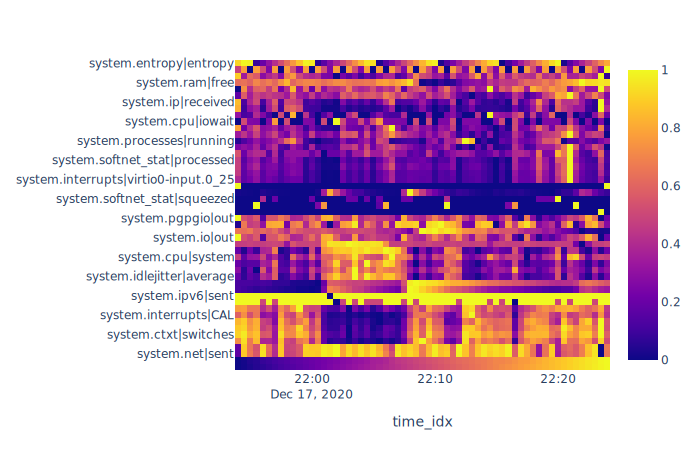

In [35]:
# now plot our heatmap
fig = px.imshow(df.transpose())
fig.update_layout(
    autosize=False,
    width=1000,
    height=1200)
# fig.show() # for interactive
fig.show("svg") # static svg so can be displayed on github, best use above line